# Machine learning

### Importations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV


### Génération d'une carte des présences/ pseudo-absences

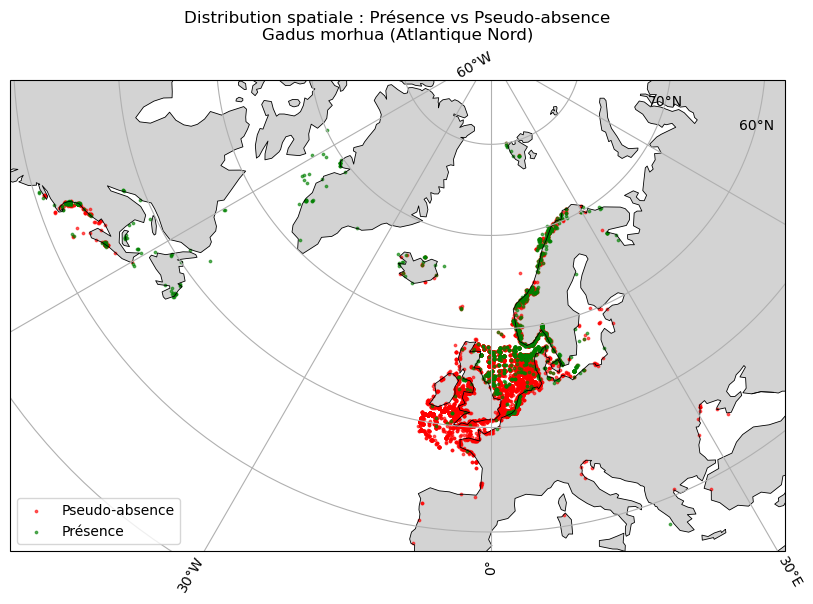

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Charger les données fusionnées
data = pd.read_csv("/home/francois/Bureau/Projet/Classification/data/gadus_total.csv")

# Séparation Présences / Pseudo-absences
pres = data[data["presence"] == 1]
abs_ = data[data["presence"] == 0]

# Définition de la zone de zoom (correspondant au min/max de nos coordonnées)
lon_min, lon_max = -73.1, 35.8
lat_min, lat_max = 37.7, 80.4

# Figure avec projection adaptée aux régions nordiques
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Ajout des continents et des traits côtiers
ax.add_feature(cfeature.LAND, facecolor="lightgrey")
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.gridlines(draw_labels=True)
ax.scatter(abs_["lon"], abs_["lat"],
           color="red", s=3, alpha=0.6,
           transform=ccrs.PlateCarree(), label="Pseudo-absence")

ax.scatter(pres["lon"], pres["lat"],
           color="green", s=3, alpha=0.6,
           transform=ccrs.PlateCarree(), label="Présence")

plt.title("Distribution spatiale : Présence vs Pseudo-absence\nGadus morhua (Atlantique Nord)")
plt.legend(loc="lower left")
plt.show()



## Normalisation des données

In [3]:
# Sélection des colonnes environnementales (on le gardes toutes pour le moments)
vars_env = [
    "temp_depth_mean", "sst_mean", "phosphate", "dis_oxygen",
    "salinity", "current_mean_surf", "current_range_surf", "ph", "chl_mean", "cloud_mean", "calcite"
]

X = data[vars_env].values
Y = data["presence"].values

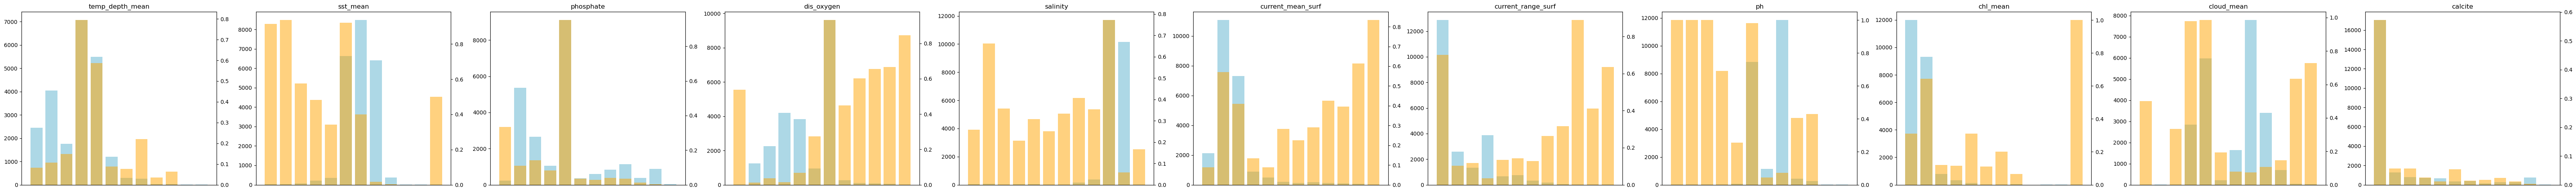


Statistiques de base :


,count,mean,std,min,25%,50%,75%,max
lon,22633.0,-26.397390,35.521493,-73.021722,-70.102390,-4.396700,3.700000,35.709264
lat,22633.0,49.890757,6.108314,37.736310,43.586420,51.248400,53.993900,79.957316
obs_year,22633.0,2023.359254,0.576734,2023.000000,2023.000000,2023.000000,2024.000000,2025.000000
temp_depth_mean,22633.0,0.233379,0.093485,0.037000,0.140000,0.241000,0.294000,0.771000
sst_mean,22633.0,10.739590,1.546237,-0.379000,9.538000,10.484000,12.148000,20.350000
chl_mean,22633.0,5.225408,4.271418,0.084000,1.333000,4.819000,7.752000,64.565002
phosphate,22633.0,0.662403,0.350554,0.058100,0.354300,0.697400,0.721500,1.802700
dis_oxygen,22633.0,6.562525,0.489528,5.165000,6.162000,6.554000,7.034000,8.583000
salinity,22633.0,32.443048,2.833026,4.552000,30.794001,32.702000,34.580002,38.657001
ph,22633.0,8.140200,0.075437,7.699000,8.048000,8.176000,8.204000,8.494000


In [4]:
# Analyse des colonnes (histogrammes + target mean)
plt.figure(figsize=[6*X.shape[1], 5])
for i in range(X.shape[1]):
    plt.subplot(1, X.shape[1], i+1)

    nbins = np.minimum(len(np.unique(X[:, i])), 12)
    e, x = np.histogram(X[:, i], nbins)
    x[-1] += 0.001

    # Moyenne de présence dans chaque bin
    conso = [
        Y[(X[:, i] >= x[j]) & (X[:, i] < x[j+1])].mean()
        if np.sum((X[:, i] >= x[j]) & (X[:, i] < x[j+1])) > 0 else 0
        for j in range(len(e))
    ]

    # Barres: densité → gris
    plt.bar(np.arange(len(e)), e, color="lightblue")

    # Axe secondaire : présence moyenne → rouge
    ax2 = plt.gca().twinx()
    ax2.bar(np.arange(len(e)), conso, alpha=0.5, color="orange")

    plt.title(vars_env[i], fontsize=12)
    plt.xticks([])

plt.tight_layout()
plt.show()

# Statistiques descriptives (variables numériques)
print("\nStatistiques de base :")
display(data.describe().T)


On remarque que pour **chl_mean, phosphate, current_range_surf, calcite** la distribution est très étalée, dominées par quelques valeurs très hautes, ou beaucoup de zero (chl_mean, current_range_surf et calcite). On leur applique alors le log1p afin que le modèle ne sur-apprenne sur les valeurs extrêmes. Puis on standardise les variables étant donné que les unités et échelles de chacunes sont très différentes.
Enfin **cloud_mean** est plus spéciale, il s'agit d'une échelle de couverture du ciel allant de 0 à 1, meme si la distribution est asymétrique si on passait au log on perdrait la symbolique linéaire de la variable ( 0 completement couvert, 1 ciel dégagé), on peut juste lui appliquer minmax.

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# On copie pour ne pas modifier l'original
data_norm = data.copy()

# Variables à transformer en log1p
log_vars = ["chl_mean", "phosphate", "current_range_surf", "calcite"]
data_norm[log_vars] = np.log1p(data_norm[log_vars])

# Standardisation
std_vars = [
    "temp_depth_mean", "sst_mean", "chl_mean", "phosphate",
    "dis_oxygen", "salinity", "ph",
    "current_mean_surf", "current_range_surf", "current_mean_surf", "calcite"
]
scaler_std = StandardScaler()
data_norm[std_vars] = scaler_std.fit_transform(data_norm[std_vars])

# MinMax pour les nuages
minmax_vars = ["cloud_mean"]
scaler_mm = MinMaxScaler()
data_norm[minmax_vars] = scaler_mm.fit_transform(data_norm[minmax_vars])
data_norm.head()


,lon,lat,obs_year,temp_depth_mean,sst_mean,chl_mean,phosphate,dis_oxygen,salinity,ph,current_mean_surf,current_range_surf,cloud_mean,calcite,presence
0,-0.819581,54.595220,2025,-0.292874,-0.079931,-0.127734,-0.445195,-0.293198,0.589824,0.567372,0.225700,-0.578103,0.678350,-0.283680,1
1,4.100000,51.950000,2025,1.835858,1.091325,1.460361,1.806905,-1.792636,0.014103,0.885527,0.234709,0.854876,0.630928,1.034022,1
2,4.100000,51.950000,2025,1.835858,1.091325,1.460361,1.806905,-1.792636,0.014103,0.885527,0.234709,0.854876,0.630928,1.034022,1
3,10.385540,63.432354,2025,1.365183,-1.198801,1.647814,-0.159050,0.854872,-1.091101,0.925300,0.761785,0.723499,0.653608,-0.485483,1
4,8.349652,63.311088,2025,0.006646,-0.869607,-0.732944,-0.786294,0.701660,-0.154625,0.474577,3.064022,1.779649,0.612371,-0.549408,1


# Test sur différents modèles (et différents split)

### Sélection finale des variables environnementales

Suite à l’analyse de corrélation entre les variables environnementales (notebook 1) et les coordonnées géographiques (latitude, longitude), plusieurs variables se sont révélées fortement colinéaires à la position spatiale: **pH**, **chl_mean** et **cloud_mean** (|r| > 0.85). On ne les donnera pas dans la suite (risque de fuite spatiale).

In [6]:
vars_select = [
    "temp_depth_mean", "sst_mean", "phosphate", "dis_oxygen",
    "salinity", "current_mean_surf", "current_range_surf", "calcite", "cloud_mean"
]

X = data_norm[vars_env].values
y = data_norm["presence"].values

## Validation croisée et différents modèles

On essaie de voir si une simple validation croisée peut fonctionner pour évaluer notre modèle.
Notre jeu de données présente une légère asymétrie entre absences et présences (~12 000 absences vs ~9 000 présences), d'ou l'idée initiale de choisir cette méthode.
De plus, même si les points proviennent d’aires géographiques différentes, ils couvrent toute la zone d’étude avec des profils environnementaux variés.

### Test d'un SVM avec noyau RBF

In [69]:
from sklearn.svm import SVC

# 1) Modèle SVM
clf_svm = SVC(kernel="rbf", probability=False, class_weight="balanced", random_state=42)

# 2) Validation croisée 10 folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

f1_scores = cross_val_score(
    clf_svm,
    X, y,
    cv=cv,
    scoring=make_scorer(f1_score),
    n_jobs=-1
)

print("F1 par fold :", f1_scores)
print("F1 moyen :", f1_scores.mean())
print("Écart-type :", f1_scores.std())

# 3) Grid-search sur C et gamma
param_grid = {
    "C":     [0.5, 1, 2, 5],
    "gamma": ["scale", 0.1, 0.05, 0.02]
}

grid = GridSearchCV(
    estimator=SVC(kernel="rbf", class_weight="balanced", random_state=42),
    param_grid=param_grid,
    scoring=make_scorer(f1_score),
    cv=cv,
    n_jobs=-1
)

grid.fit(X, y)

print("Meilleurs hyperparamètres :", grid.best_params_)
print("Meilleur F1 (CV) :", grid.best_score_)


F1 par fold : [0.94266176 0.93759832 0.93697479 0.93896714 0.92962185 0.93368146
 0.94233766 0.94386694 0.93845345 0.93888303]
F1 moyen : 0.938304640242141
Écart-type : 0.004074513106170537
Meilleurs hyperparamètres : {'C': 5, 'gamma': 0.1}
Meilleur F1 (CV) : 0.9391700658181479


## Test de Random Forest avec 300 arbres

In [70]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer

# On crée un modèle avec 300 arbres
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,   
    n_jobs=-1        
)

# On fait une validation croisée avec 20 folds
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

# Évaluation du modèle avec la métrique F1
f1_scores = cross_val_score(
    rf, X, y,
    cv=cv,
    scoring=make_scorer(f1_score),
    n_jobs=-1
)

# Affichage des résultats
print("F1-score pour chaque pli de validation croisée :")
print(f1_scores)

# Moyenne et écart-type
moyenne = f1_scores.mean()
ecart_type = f1_scores.std()

print("F1-score moyen :", moyenne)
print("Ecart-type :", ecart_type)


F1-score pour chaque pli de validation croisée :
[0.93907563 0.95580678 0.95670103 0.93873313 0.94583333 0.9526749
 0.94683027 0.94824017 0.93568465 0.93801653 0.94736842 0.9369183
 0.94834711 0.94984647 0.94650206 0.94877049 0.94008264 0.95553257
 0.94178794 0.94715026]
F1-score moyen : 0.945995133965746
Ecart-type : 0.006282524489080725


### Limite de la validation croisée classique : fuite spatiale

Les résultats avec la validation croisée sur les 2 modèles semblent excellents, avec des F1-scores moyens proches de **0.95**, ce qui nous a semblé très suspect. 

**Ces performances étaient en effet trompeuses**.
En effet, les points proches dans l’espace partagent presque exactement les mêmes conditions environnementales. Lorsqu’un modèle voit un point d’entraînement et qu’un point de test se trouve au même endroit ou juste à côté, il n’a plus besoin d’apprendre une véritable relation écologique, il “copie-colle” seulement ce qu’il a vu.  
On a donc sans doute une **fuite spatiale**, et cela fausse complètement l’évaluation du modèle.

### Solution : La séparation géographique des données

Pour éviter que le modèle ne triche, nous avons remplacé la validation croisée classique par une **validation spatiale**, où les zones géographiques d’entraînement et de test sont différentes. Ainsi, le modèle est obligé de **prédire dans des régions jamais vues**, ce qui donne une estimation beaucoup plus réaliste de sa capacité de généralisation.

## Changer le split pour un split plus géographique 

### Découpage géographique des données

Pour mieux évaluer la capacité de généralisation spatiale de notre modèle, nous avons mis en place un **découpage géographique du jeu de données**.  
L’idée est de ne plus séparer les données de façon aléatoire, mais de **créer des blocs correspondant à différentes zones longitudinales**.  
Chaque bloc représente ainsi une région de l'Atlantique nord, utilisée tour à tour comme jeu de test, tandis que les autres servent à l’entraînement.

### Utilisation de GeoPandas

Nous avons utilisé la bibliothèque **GeoPandas**, qui étend les fonctionnalités de **pandas** pour la manipulation de données géographiques. L’avantage de GeoPandas est qu’il facilite la **visualisation sur fond de carte** (ici via `naturalearth.land`) et la création de zones géographiques

### Méthode de découpage

Nous avons divisé les données selon leur longitude, en 6 zones assez équivalentes en nombre points:
```python
gdata["block_id"] = pd.qcut(gdata["lon"], q=n_blocs, labels=False)


In [7]:
import geopandas as gpd
from shapely.geometry import Point
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# Conversion en GeoDataFrame
geometry = gpd.points_from_xy(data_norm.lon, data_norm.lat)
gdata = gpd.GeoDataFrame(data_norm, geometry=geometry, crs="EPSG:4326")

print("Données ML chargées :", gdata.shape)


Données ML chargées : (22633, 16)


/tmp/ipykernel_85004/2812689329.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/tmp/ipykernel_85004/2812689329.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/tmp/ipykernel_85004/2812689329.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use th

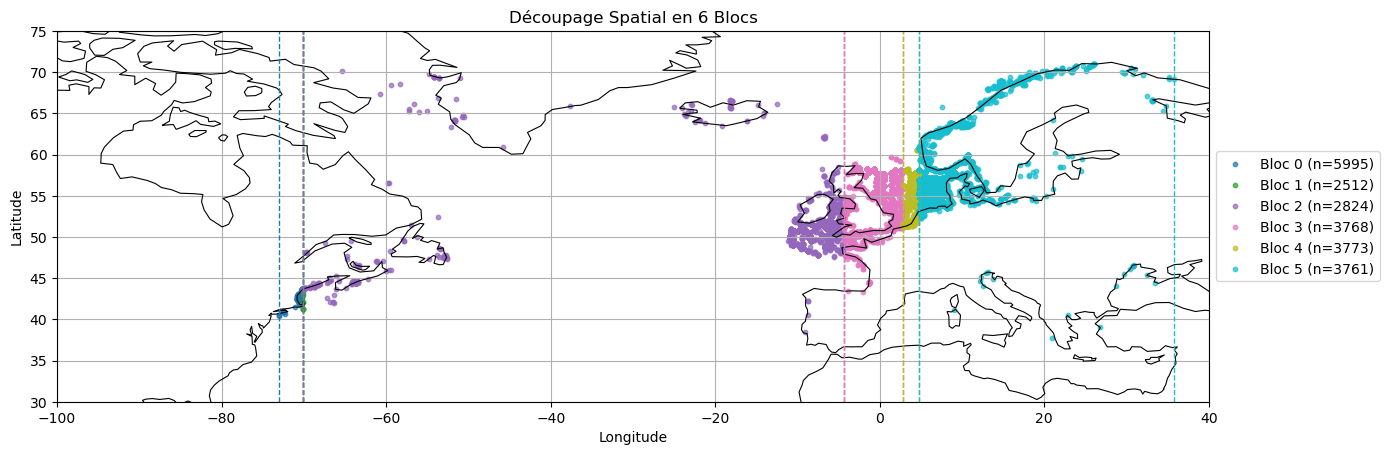

In [8]:
from geodatasets import get_path

# Nb de blocs
n_blocs = 6
gdata["block_id"] = pd.qcut(gdata["lon"], q=n_blocs, labels=False)

# Fond de carte
world = gpd.read_file(get_path('naturalearth.land'))

# Couleurs par bloc
unique_blocks = sorted(gdata["block_id"].unique())
colors_blocks = plt.cm.tab10(np.linspace(0,1,len(unique_blocks)))

# Plot
fig, ax = plt.subplots(figsize=(14, 10))
world.boundary.plot(ax=ax, linewidth=0.8, color="black")

for blk, col in zip(unique_blocks, colors_blocks):
    subset = gdata[gdata["block_id"] == blk]
    
    ax.scatter(
        subset["lon"], subset["lat"],
        c=col,
        s=10,
        alpha=0.7,
        label=f"Bloc {blk} (n={len(subset)})"
    )

    # Limites verticales de chaque bloc
    x0 = subset["lon"].min()
    x1 = subset["lon"].max()
    ax.axvline(x=x0, color=col, linestyle="--", linewidth=1)
    ax.axvline(x=x1, color=col, linestyle="--", linewidth=1)

# On zoom sur l'Atlantique Nord
ax.set_xlim([-100, 40])
ax.set_ylim([30, 75])

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Découpage Spatial en 6 Blocs")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


## Test n°2 avec Random Forest

In [65]:
from sklearn.metrics import f1_score

scores = []

for block in sorted(gdata["block_id"].unique()):
    train = gdata[gdata["block_id"] != block].index
    test  = gdata[gdata["block_id"] == block].index
    
    clf = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        class_weight="balanced",
        random_state=42
    )
    
    clf.fit(X[train], y[train])
    
    # prédictions binaires directes
    y_pred = clf.predict(X[test])
    
    f1 = f1_score(y[test], y_pred)
    scores.append(f1)
    print(f"Bloc {block} → F1-score = {f1:.3f}")

print("\nRésultat Final Spatial-CV :")
print(f"F1-score moyen = {pd.Series(scores).mean():.3f} ± {pd.Series(scores).std():.3f}")



Bloc 0 → F1-score = 0.691
Bloc 1 → F1-score = 0.984
Bloc 2 → F1-score = 0.012
Bloc 3 → F1-score = 0.000
Bloc 4 → F1-score = 0.418

Résultat Final Spatial-CV :
F1-score moyen = 0.421 ± 0.429


Nous observons une chute importante des performances du modèle Random Forest par rapport à la validation croisée classique.  
Le F1-score moyen est nettement plus faible et surtout très variable d’un bloc à l’autre, ce qui montre que le modèle n’arrive pas à généraliser correctement d’une région à une autre.

Le cas du bloc 3: il correspond à une zone couvrant la mer du Nord, les côtes britanniques et la Manche. Lorsque cette région est mise en test, le modèle n’arrive plus du tout à prédire la présence de morue (F1 = 0).  
Cela signifie que **les conditions environnementales et la dynamique de présence dans cette zone sont différentes des autres régions**, et que le modèle n’a que très peu d'information similaire dans les blocs d’entraînement.


## Clustering par zone

Fold 0 → F1 = 0.006, n=8907
Fold 1 → F1 = 0.000, n=6371
Fold 2 → F1 = 0.321, n=3657
Fold 3 → F1 = 0.158, n=3170
Fold 4 → F1 = 0.542, n=451
Fold 5 → F1 = 0.559, n=77

F1-score moyen = 0.264 ± 0.229


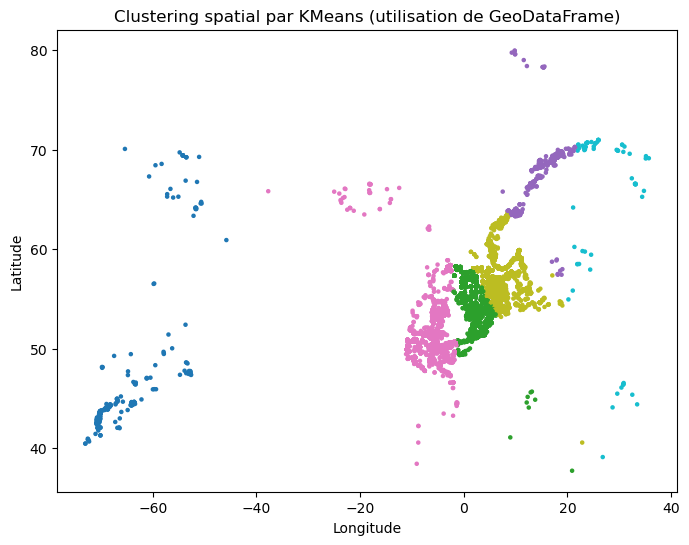

In [79]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GroupKFold

# 1) Clustering spatial
coords = gdata[["lat", "lon"]].values
n_clusters = 6
gdata["zone"] = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(coords)

# 2) Définition des variables
variables = ["temp_depth_mean","sst_mean","phosphate","dis_oxygen",
            "salinity","current_mean_surf","current_range_surf","calcite"]
X = gdata[variables].values
y = gdata["presence"].values

# 3) Validation Leave-One-Zone-Out
cv = GroupKFold(n_splits=n_clusters)
clf = RandomForestClassifier(n_estimators=400, class_weight="balanced", random_state=42)

scores = []
for fold, (train_idx, test_idx) in enumerate(cv.split(X, y, groups=gdata["zone"])):
    clf.fit(X[train_idx], y[train_idx])
    y_pred = clf.predict(X[test_idx])
    f1 = f1_score(y[test_idx], y_pred)

    scores.append(f1)
    print(f"Fold {fold} → F1 = {f1:.3f}, n={len(test_idx)}")

print(f"\nF1-score moyen = {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# 4) Visualisation des clusters spatiaux sur carte
plt.figure(figsize=(8,6))
plt.scatter(gdata["lon"], gdata["lat"], c=gdata["zone"], cmap="tab10", s=5)
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title("Clustering spatial par KMeans (utilisation de GeoDataFrame)")
plt.show()

Encore une fois le constat est le même et la méthode des K-means pour la séparation géographique des données ne permet pas de résoudre le problème de généralisation de l'apprentissage (voire pire, ici on crée des clusters avec un nombre de points inégaux étant donné que ils sont établis selon leurs distance lat/lon autour des centres.
**Au final, le modèle n’ayant vu qu’une gamme limitée de valeurs pour chaque zone, il extrapole mal.**

## Correction du clustering en micro-cluster 

Pour éviter d'oublier des zones environnementalement spécifique lors de l'apprentissage, on essaie de changer de méthode:
Un découpage en 100 micro-zones géographiques a été réalisé à l’aide d’un clustering K-Means sur les coordonnées (latitude, longitude).
Dix validations croisées indépendantes ont ensuite été effectuées en sélectionnant aléatoirement 20 % des micro-zones comme ensemble de test à chaque fois.
Ainsi on a plus de chance lors de l'apprentissage d'avoir des extraits de zones spécifiques, le fait de faire 10 folds permet de s'assurer qu'en moyenne on ait un tirage de zone cohérents.

### Choix de 100 micro-clusters

Nous avons fixé le nombre de micro-clusters à **K = 100**.  
L’objectif n’est pas d’obtenir des zones parfaitement équilibrées en présence/absence, mais de créer des zones suffisamment grande pour éviter la fuite spatiale et petite pour éviter de cacher des régions écologiquement spécifiques.
Avec 100 clusters, on conserve en moyenne quelques centaines d’observations par zone, ce qui reste statistiquement exploitable tout en préservant la variabilité spatiale.

In [22]:
import random

# 1) Clustering spatial en 100 micro-zones
coords = gdata[["lat", "lon"]].to_numpy()
K_micro = 100
kmeans = KMeans(n_clusters=K_micro, random_state=42, n_init=20)
gdata["zone_micro"] = kmeans.fit_predict(coords)

# boucle de 10 folds
scores = []
for seed in range(10):
    random.seed(seed)

    # 2) Séparer les clusters : 80% train / 20% test
    clusters = list(gdata["zone_micro"].unique())  # on met la liste dans une variable
    random.shuffle(clusters)  # on mélange la liste
    n_test = int(0.2 * len(clusters))
    test_clusters = clusters[:n_test]


    train_idx = gdata[~gdata["zone_micro"].isin(test_clusters)].index
    test_idx  = gdata[gdata["zone_micro"].isin(test_clusters)].index

    # 3) Entraînement du modèle
    variables = ["temp_depth_mean","sst_mean","phosphate","dis_oxygen",
        "salinity","current_mean_surf","current_range_surf","calcite"]

    X_train, y_train = gdata.loc[train_idx, variables], gdata.loc[train_idx, "presence"]
    X_test,  y_test  = gdata.loc[test_idx,  variables], gdata.loc[test_idx,  "presence"]

    clf = RandomForestClassifier(
        n_estimators=400,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)

    # 4) Évaluation
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    scores.append(f1)
    print(f"Fold {seed+1}: F1-score = {f1:.3f} ({len(test_idx)} points test)")

print(f"\nF1-score moyen (10 folds) = {np.mean(scores):.3f} ± {np.std(scores):.3f}")


Fold 1: F1-score = 0.007 (5693 points test)
Fold 2: F1-score = 0.469 (2082 points test)
Fold 3: F1-score = 0.243 (3017 points test)
Fold 4: F1-score = 0.038 (4701 points test)
Fold 5: F1-score = 0.009 (10005 points test)
Fold 6: F1-score = 0.256 (2449 points test)
Fold 7: F1-score = 0.305 (3389 points test)
Fold 8: F1-score = 0.004 (10267 points test)
Fold 9: F1-score = 0.024 (9082 points test)
Fold 10: F1-score = 0.400 (2796 points test)

F1-score moyen (10 folds) = 0.175 ± 0.171


Les résultats restent cependant faibles (F1-score moyen ≈ 0.17), même si la variabilité entre folds est plus stable que dans les tests précédents. Cela montre que le modèle n’arrive toujours pas à apprendre une relation cohérente entre environnement et présence de morue lorsqu’il doit prédire dans des zones non observées.

Cette faible performance ne vient probablement pas uniquement du modèle, mais aussi de la manière dont nos données ont été construites, notamment des **TGB (Tables Géoréférencées de Base)**. Le problème vient sans doute du fait de considérer que la présence des poissons demersaux ayant servis à la construcition de nos TGB correspondait à une absence de morue. Or, ce n’est pas toujours vrai : On a sans doute des points d’absence surement très proches, voire superposés, à des points de présence. Cela introduit sans doute du bruit dans les données.

On décide alors de **filtrer et supprimer ces pseudo-absences “douteuses”**, dans un certain rayon et une certaine proximité temporelle autour des points de présence de morue (on choisira 30km).


# Essayons de changer les TGB

Pour cela, on utilise un **BallTree**, une structure d’arbre spatial qui permet de trouver très rapidement la présence la plus proche d’un point, en calculant la distance sur la sphère terrestre (= haversine dans BallTree).  
On conserve uniquement les absences situées à plus de 30 km d’une présence, afin de réduire le bruit dans les données.

In [11]:
from sklearn.neighbors import BallTree

# 1) Séparer les présences et absences
pres = gdata[gdata["presence"] == 1]
abs_  = gdata[gdata["presence"] == 0]

# 2) Construire un arbre spatial sur les présences
# On convertit les coordonnées en radians pour le calcul de distances sur la sphère terrestre
coords_pres = np.radians(pres[["lat", "lon"]].values)
tree = BallTree(coords_pres, metric="haversine")  # haversine = distance sur la sphère

# 3) Calculer la distance de chaque pseudo-absence au point de présence le plus proche
coords_abs = np.radians(abs_[["lat", "lon"]].values)
distances, _ = tree.query(coords_abs, k=1)  # distance en radians vers la présence la plus proche

# 4) Convertir en kilomètres
dist_km = distances[:, 0] * 6371  # rayon moyen de la Terre en km

# 5) Garder uniquement les absences situées à plus de 30 km d'une présence
rayon = 30
absfiltrees = abs_.iloc[dist_km > rayon]

# 6) Recomposer le jeu de données filtré
gdata2 = pd.concat([pres, absfiltrees])
print(f"Points initiaux : {len(gdata)}  →  après filtrage : {len(gdata2)}")
print(len(absfiltrees))
print(len(pres))

Points initiaux : 22633  →  après filtrage : 14196
4280
9916


### Carte de nos nouvelles données

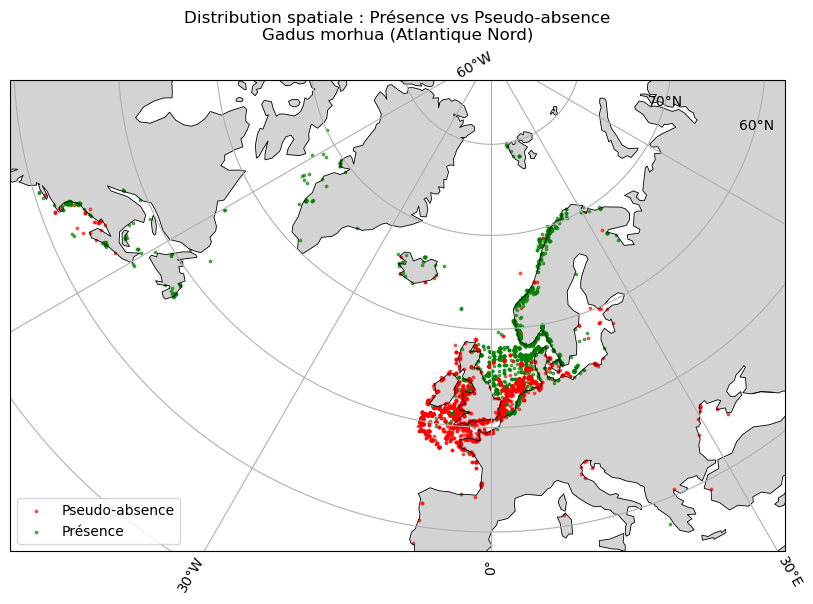

In [12]:
# Définition de la zone de zoom (correspondant au min/max de nos coordonnées)
lon_min, lon_max = -73.1, 35.8
lat_min, lat_max = 37.7, 80.4

# Figure avec projection adaptée aux régions nordiques
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Ajout des continents & traits côtiers
ax.add_feature(cfeature.LAND, facecolor="lightgrey")
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.gridlines(draw_labels=True)
ax.scatter(absfiltrees["lon"], absfiltrees["lat"],
           color="red", s=3, alpha=0.6,
           transform=ccrs.PlateCarree(), label="Pseudo-absence")

ax.scatter(pres["lon"], pres["lat"],
           color="green", s=3, alpha=0.6,
           transform=ccrs.PlateCarree(), label="Présence")

plt.title("Distribution spatiale : Présence vs Pseudo-absence\nGadus morhua (Atlantique Nord)")
plt.legend(loc="lower left")
plt.show()

## On test à nouveau un random forest avec un micro-clustering spatial

On a décidé, en plus, de faire apparaitre la répartition des les clusters à chaque fold.

Fold 1: F1-score = 0.779 (938 points test)


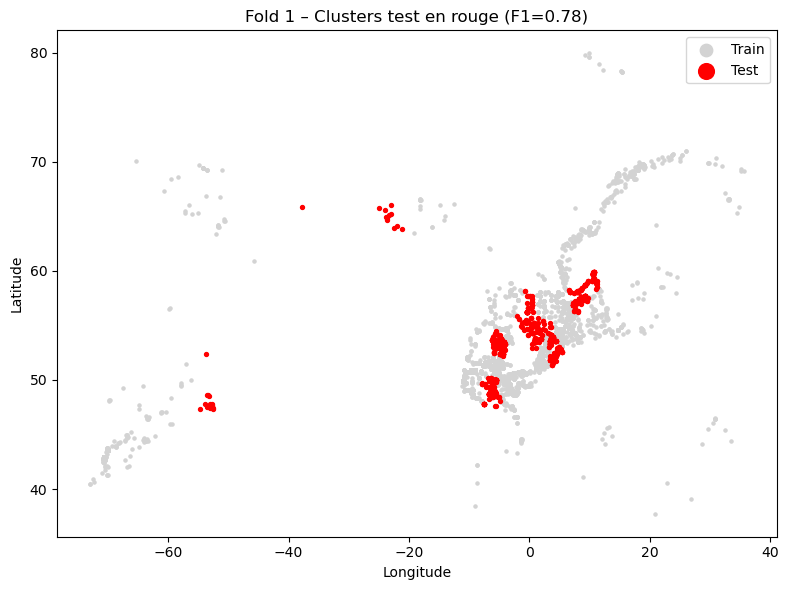

Fold 2: F1-score = 0.593 (1892 points test)


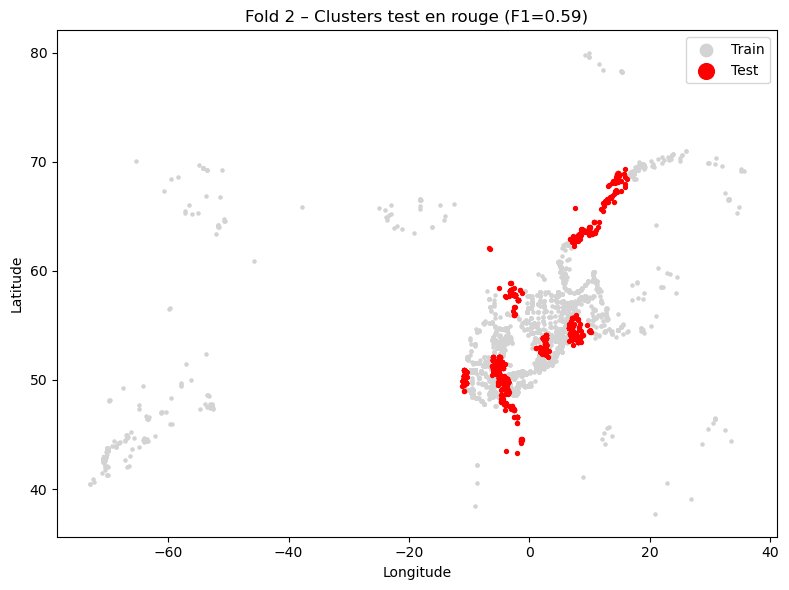

Fold 3: F1-score = 0.844 (463 points test)


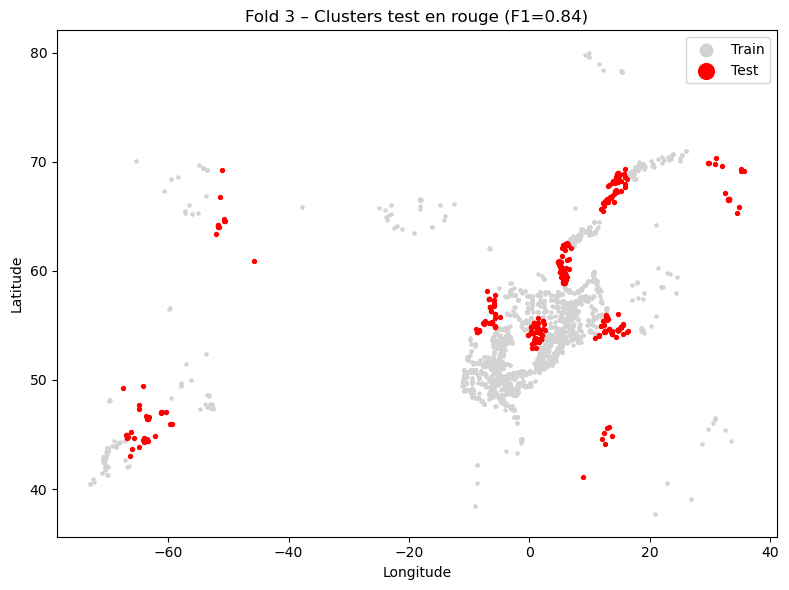

Fold 4: F1-score = 0.995 (6369 points test)


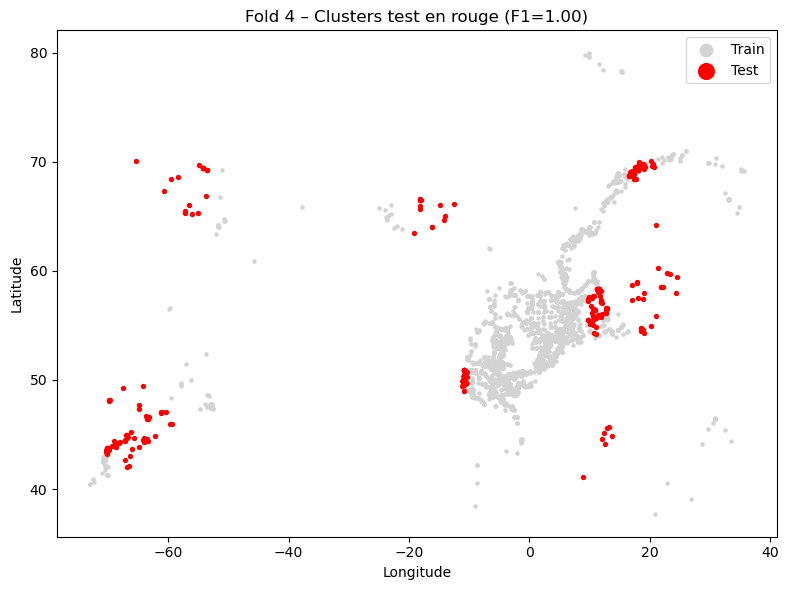

Fold 5: F1-score = 0.819 (914 points test)


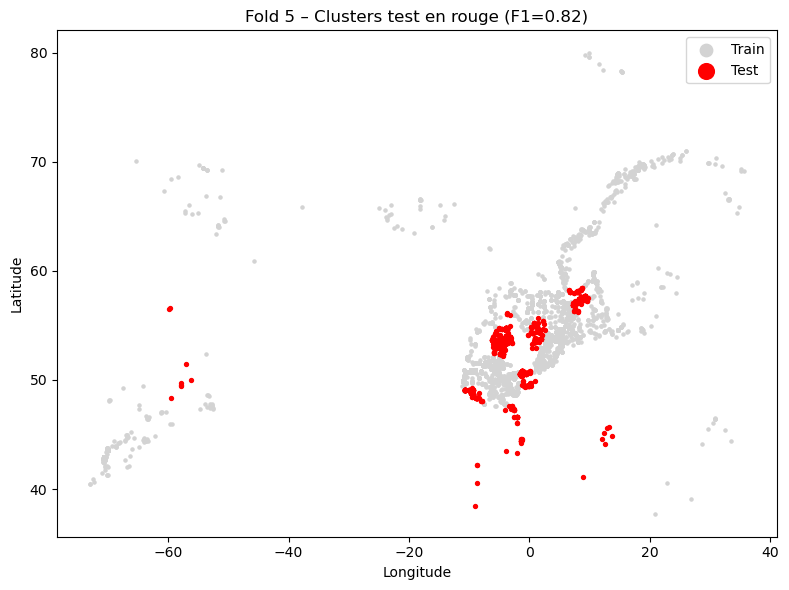

Fold 6: F1-score = 0.872 (1162 points test)


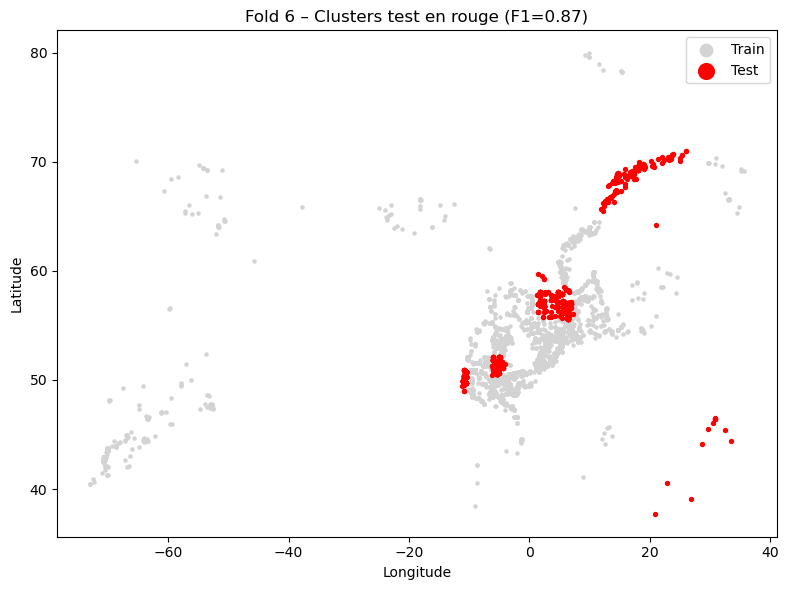

Fold 7: F1-score = 0.776 (830 points test)


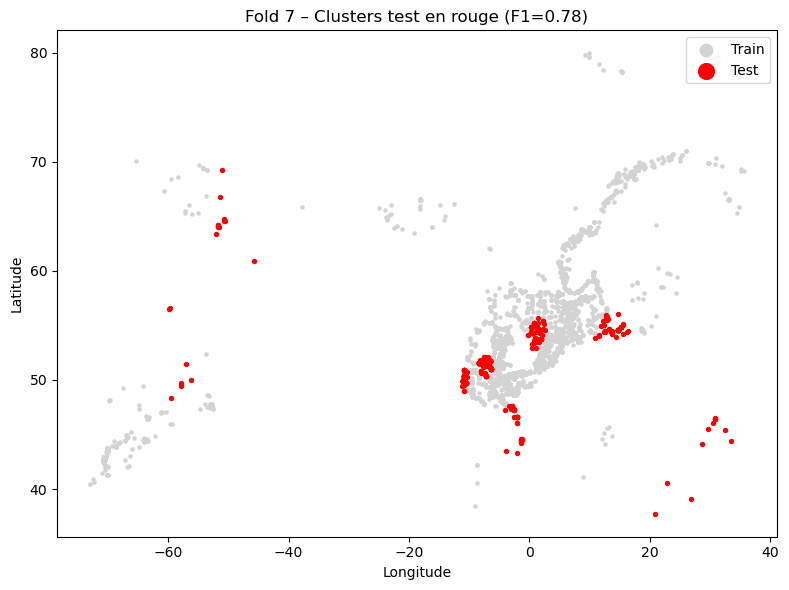

Fold 8: F1-score = 0.852 (889 points test)


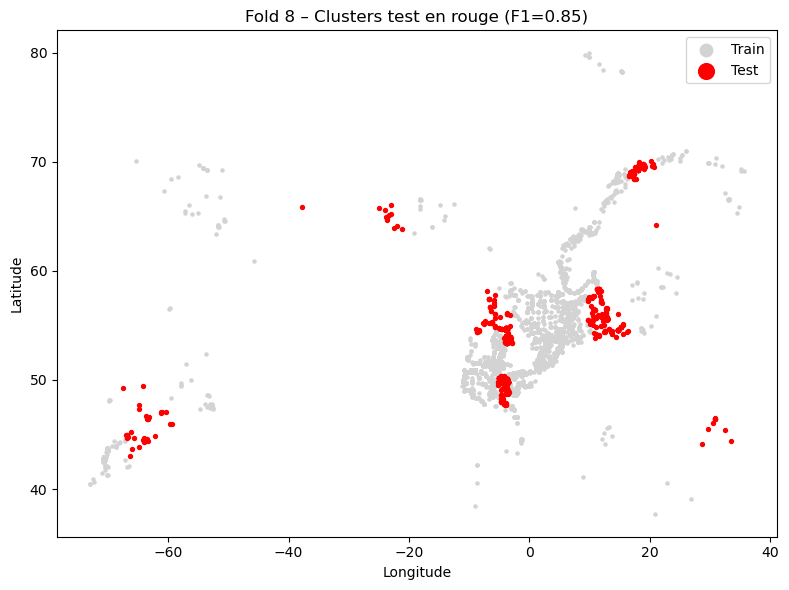

Fold 9: F1-score = 0.960 (793 points test)


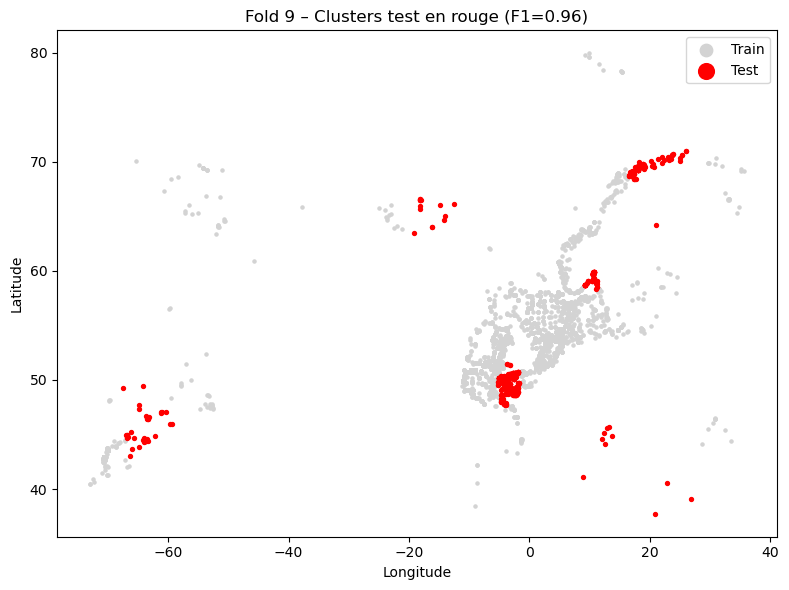

Fold 10: F1-score = 0.989 (6616 points test)


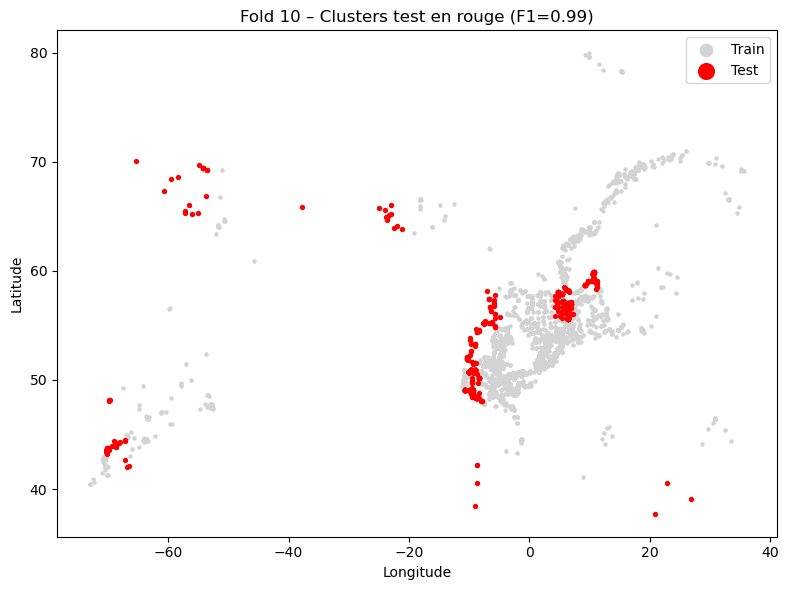


F1-score moyen (10 folds) = 0.848 ± 0.114


In [14]:
from sklearn.cluster import KMeans

# 1) Clustering spatial en ~100 micro-zones
coords = gdata2[["lat", "lon"]].to_numpy()
K_micro = 100
kmeans = KMeans(n_clusters=K_micro, random_state=42, n_init=20)
gdata2["zone_micro"] = kmeans.fit_predict(coords)

# boucle de 10 folds
scores = []
for seed in range(10):
    random.seed(seed)

    # 2) Séparer les clusters : 80% train / 20% test
    clusters = list(gdata2["zone_micro"].unique())  # on met la liste dans une variable
    random.shuffle(clusters)  # on mélange la liste
    n_test = int(0.2 * len(clusters))
    test_clusters = clusters[:n_test]

    train_idx = gdata2[~gdata2["zone_micro"].isin(test_clusters)].index
    test_idx  = gdata2[gdata2["zone_micro"].isin(test_clusters)].index

    # 3) Entraînement du modèle
    variables = [
        "temp_depth_mean","sst_mean","phosphate","dis_oxygen",
        "salinity","current_mean_surf","current_range_surf","calcite"
    ]

    X_train, y_train = gdata2.loc[train_idx, variables], gdata2.loc[train_idx, "presence"]
    X_test,  y_test  = gdata2.loc[test_idx,  variables], gdata2.loc[test_idx,  "presence"]

    clf = RandomForestClassifier(
        n_estimators=400,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)

    # 4) Évaluation
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    scores.append(f1)
    print(f"Fold {seed+1}: F1-score = {f1:.3f} ({len(test_idx)} points test)")

    # 5) Visualisation du découpage pour ce fold
    plt.figure(figsize=(8,6))
    # clusters d'entraînement en gris
    plt.scatter(
        gdata2.loc[train_idx, "lon"],
        gdata2.loc[train_idx, "lat"],
        c="lightgray", s=5, label="Train"
    )
    # clusters de test en rouge
    plt.scatter(
        gdata2.loc[test_idx, "lon"],
        gdata2.loc[test_idx, "lat"],
        c="red", s=8, label="Test"
    )
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Fold {seed+1} – Clusters test en rouge (F1={f1:.2f})")
    plt.legend(markerscale=4)
    plt.tight_layout()
    plt.show()

# Résumé final
print(f"\nF1-score moyen (10 folds) = {np.mean(scores):.3f} ± {np.std(scores):.3f}")


Le nettoyage des données a eu un impact majeur : le F1-score moyen passe de **0.17 à 0.85 ± 0.10**.

Ce résultat confirme que le principal problème ne venait pas uniquement du modèle ou du découpage spatial, mais aussi de nos données d’entraînement. Cette étape de filtrage des pseudo-absences était essentielle, elle permet enfin au modèle de généraliser correctement dans l’espace.


# Recherche d'un meilleur modèle

[LightGBM] [Info] Number of positive: 3833, number of negative: 3365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1977
[LightGBM] [Info] Number of data points in the train set: 7198, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

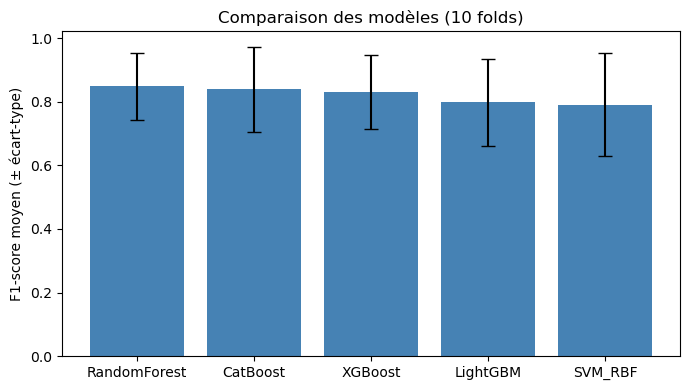

In [21]:
import numpy as np
import pandas as pd
import random
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Clustering spatial en ~100 micro-zones
coords = gdata2[["lat", "lon"]].to_numpy()
K_micro = 100
kmeans = KMeans(n_clusters=K_micro, random_state=42, n_init=20)
gdata2["zone_micro"] = kmeans.fit_predict(coords)

# Définition des modèles à comparer
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=400, class_weight="balanced", random_state=42, n_jobs=-1
    ),
    "CatBoost": CatBoostClassifier(
        iterations=400, learning_rate=0.05, depth=6,
        loss_function="Logloss", eval_metric="F1",
        verbose=False, random_seed=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=400, learning_rate=0.05, max_depth=6,
        eval_metric="logloss", random_state=42, n_jobs=-1
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=400, learning_rate=0.05, max_depth=6,
        class_weight="balanced", random_state=42, n_jobs=-1
    ),
    "SVM_RBF": SVC(                      
        kernel="rbf",
        C=1,
        gamma="scale",
        class_weight="balanced",
        probability=False,
        random_state=42
    )
}

# Variables d'entrée
variables = [
    "temp_depth_mean","sst_mean","phosphate","dis_oxygen",
    "salinity","current_mean_surf","current_range_surf","calcite"
]

# Boucle principale
results = {name: [] for name in models.keys()}
n_folds = 10

for fold in range(n_folds):
    random.seed(fold)
    clusters = list(gdata2["zone_micro"].unique())
    random.shuffle(clusters)
    n_test = int(0.2 * len(clusters))
    test_clusters = clusters[:n_test]

    train_idx = gdata2[~gdata2["zone_micro"].isin(test_clusters)].index
    test_idx  = gdata2[gdata2["zone_micro"].isin(test_clusters)].index

    X_train, y_train = gdata2.loc[train_idx, variables], gdata2.loc[train_idx, "presence"]
    X_test,  y_test  = gdata2.loc[test_idx,  variables], gdata2.loc[test_idx,  "presence"]

    # Boucle sur les modèles
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        results[name].append(f1)

# Résumé global des F1-scores
summary = pd.DataFrame({
    model: [np.mean(scores), np.std(scores)]
    for model, scores in results.items()
}, index=["F1_mean", "F1_std"]).T.sort_values("F1_mean", ascending=False)

print("Résultats comparés (10 folds) :\n")
print(summary.round(3))

# Visualisation
plt.figure(figsize=(7,4))
plt.bar(summary.index, summary["F1_mean"], yerr=summary["F1_std"], capsize=5, color="steelblue")
plt.ylabel("F1-score moyen (± écart-type)")
plt.title("Comparaison des modèles (10 folds)")
plt.tight_layout()
plt.show()


## Meilleur modèle ?

Au final aucun modèle se détache significativement de autres pour sa performance, on choisira tout de même pour la suite **Catboost** qui est en moyenne en peu plus performant.

# Amélioration de la performance de Catboost sur notre modèle

**Nous utilisons Optuna pour optimiser automatiquement les hyperparamètres du modèle CatBoost.**  
À chaque combinaison de paramètres testée, le modèle est évalué non pas sur un seul split spatial, mais sur 5 répétitions : à chaque fois, 20 % des micro-clusters sont tirés au hasard comme zone test.  
Cette approche permet de vérifier si un jeu d’hyperparamètres fonctionne bien dans plusieurs configurations géographiques différentes, et pas seulement sur une zone particulière. 

In [88]:
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import GroupKFold

def objective(trial):
    # Hyperparamètre à optimiser
    params = {
        "iterations": 400,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10, log=True),
        "border_count": trial.suggest_int("border_count", 32, 128),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "random_seed": 42,
        "verbose": False,
    }

    # Validation spatiale en 5 folds
    # Ici on garde les 100 micro-clusters fixés dans gdata2["zone_micro"]
    cv = GroupKFold(n_splits=5)
    f1_scores = []

    for train_idx, test_idx in cv.split(
        gdata2[variables], gdata2["presence"], groups=gdata2["zone_micro"]
    ):
        X_train, y_train = gdata2.iloc[train_idx][variables], gdata2.iloc[train_idx]["presence"]
        X_test,  y_test  = gdata2.iloc[test_idx][variables],  gdata2.iloc[test_idx]["presence"]

        # Poids automatiques selon le déséquilibre de classes
        class_weights = [1, len(y_train) / sum(y_train)]

        # Entraînement du modèle
        model = CatBoostClassifier(**params, class_weights=class_weights)
        model.fit(X_train, y_train, verbose=False)

        # F1-score
        y_pred = model.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred))

    # On renvoie le score moyen sur les 5 folds
    return np.mean(f1_scores)


# Lancement de l'optimisation
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Meilleurs paramètres trouvés :", study.best_params)
print("F1-score moyen obtenu :", study.best_value)


[I 2025-11-02 17:58:13,838] A new study created in memory with name: no-name-79195512-c58d-471f-ab2f-c14d2503b53c
[I 2025-11-02 17:58:18,431] Trial 0 finished with value: 0.8799657484605958 and parameters: {'learning_rate': 0.09028253377520501, 'depth': 7, 'l2_leaf_reg': 6.8655046133015505, 'border_count': 35, 'subsample': 0.7067318382746638}. Best is trial 0 with value: 0.8799657484605958.
[I 2025-11-02 17:58:22,481] Trial 1 finished with value: 0.8386518460729864 and parameters: {'learning_rate': 0.05680814433275831, 'depth': 5, 'l2_leaf_reg': 0.14043511314082824, 'border_count': 69, 'subsample': 0.6850308914257186}. Best is trial 0 with value: 0.8799657484605958.
[I 2025-11-02 17:58:27,132] Trial 2 finished with value: 0.8775005827827392 and parameters: {'learning_rate': 0.03572781996018793, 'depth': 6, 'l2_leaf_reg': 0.012955453766916711, 'border_count': 48, 'subsample': 0.9872952897153356}. Best is trial 0 with value: 0.8799657484605958.
[I 2025-11-02 17:58:31,593] Trial 3 finishe

Meilleurs paramètres trouvés : {'learning_rate': 0.010383193275469922, 'depth': 7, 'l2_leaf_reg': 0.04166136404807165, 'border_count': 115, 'subsample': 0.9747141291910193}
F1-score moyen obtenu : 0.9051386291308263


Meilleurs paramètres trouvés : {'learning_rate': 0.014553156523089935, 'depth': 9, 'l2_leaf_reg': 1.9903677344025525, 'border_count': 58, 'subsample': 0.6514083290973414}
F1-score moyen obtenu : 0.9064815220033996

Meilleurs paramètres trouvés : {'learning_rate': 0.01533891116698427, 'depth': 9, 'l2_leaf_reg': 0.0032529038868713894, 'border_count': 96, 'subsample': 0.6912894676458908}
F1-score moyen obtenu : 0.9017873027692163

Meilleurs paramètres trouvés : {'learning_rate': 0.010383193275469922, 'depth': 7, 'l2_leaf_reg': 0.04166136404807165, 'border_count': 115, 'subsample': 0.9747141291910193}
F1-score moyen obtenu : 0.9051386291308263


# Analyse de l'importance des variables avec Catboost

Après avoir validé la robustesse du modèle, nous essayons d'identifier quelles variables environnementales contribuent le plus à la prédiction de présence de morue.  
Le modèle CatBoost avec une combinaison de paramètres obtenue avec optuna est entraîné sur 20 splits spatiaux différents, et pour chaque fold, nous stockons les importances de variables retournées par le modèle.  
En fin d’exécution, nous calculons la **moyenne des importances sur l’ensemble des folds**.

Fold 01 → F1-score = 0.987
Fold 02 → F1-score = 0.783
Fold 03 → F1-score = 0.834
Fold 04 → F1-score = 0.987
Fold 05 → F1-score = 0.764
Fold 06 → F1-score = 0.747
Fold 07 → F1-score = 0.815
Fold 08 → F1-score = 0.862
Fold 09 → F1-score = 0.828
Fold 10 → F1-score = 0.893
Fold 11 → F1-score = 0.984
Fold 12 → F1-score = 0.883
Fold 13 → F1-score = 0.985
Fold 14 → F1-score = 0.988
Fold 15 → F1-score = 0.980
Fold 16 → F1-score = 0.990
Fold 17 → F1-score = 0.649
Fold 18 → F1-score = 0.973
Fold 19 → F1-score = 0.994
Fold 20 → F1-score = 0.826

Résultats globaux :
F1-score moyen (10 folds) = 0.887 ± 0.101


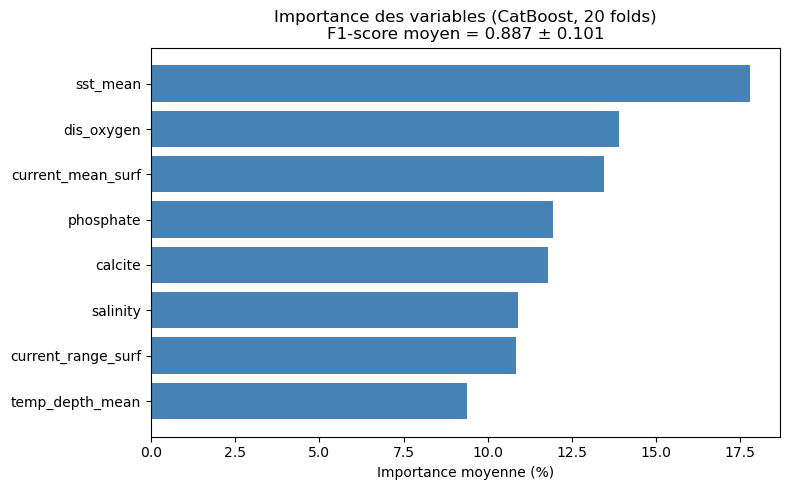


Top 5 variables les plus importantes (moyenne sur 10 folds) :
  sst_mean                  → importance = 17.79
  dis_oxygen                → importance = 13.90
  current_mean_surf         → importance = 13.46
  phosphate                 → importance = 11.93
  calcite                   → importance = 11.78


In [90]:
# 1) Clustering spatial en ~100 micro-zones
coords = gdata2[["lat", "lon"]].to_numpy()
K_micro = 100
kmeans = KMeans(n_clusters=K_micro, random_state=42, n_init=20)
gdata2["zone_micro"] = kmeans.fit_predict(coords)

# Variables d'entrée
variables = [
    "temp_depth_mean","sst_mean","dis_oxygen",
    "salinity","current_mean_surf","current_range_surf","calcite","phosphate"
]

scores = []
feature_importances = []

# 2) Boucle sur 20 folds
n_folds = 20
for fold in range(n_folds):
    # Split clusters 80% / 20%
    clusters = list(gdata2["zone_micro"].unique())
    random.shuffle(clusters)
    n_test = int(0.2 * len(clusters))
    test_clusters = clusters[:n_test]

    train_idx = gdata2[~gdata2["zone_micro"].isin(test_clusters)].index
    test_idx  = gdata2[gdata2["zone_micro"].isin(test_clusters)].index

    X_train, y_train = gdata2.loc[train_idx, variables], gdata2.loc[train_idx, "presence"]
    X_test,  y_test  = gdata2.loc[test_idx,  variables], gdata2.loc[test_idx,  "presence"]

    # Modèle CatBoost avec les hyperparamètres optimisés de optuna
    clf = CatBoostClassifier(
        iterations=400,
        learning_rate=0.01455,
        depth=9,
        l2_leaf_reg=1.99,
        border_count=58,
        subsample=0.65,     
        loss_function="Logloss",
        eval_metric="F1",
        class_weights=[1, len(y_train)/sum(y_train)],
        random_seed=fold,
        verbose=False
    )


    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # F1-score du fold
    f1 = f1_score(y_test, y_pred)
    scores.append(f1)
    print(f"Fold {fold+1:02d} → F1-score = {f1:.3f}")

    # Stocker les importances
    feature_importances.append(clf.get_feature_importance())

# 3) Résumé global des F1-scores
print("\nRésultats globaux :")
print(f"F1-score moyen (10 folds) = {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# 4) Moyenne des importances sur tous les folds
feature_importances = np.array(feature_importances)
mean_importances = feature_importances.mean(axis=0)

imp_df = pd.DataFrame({
    "Variable": variables,
    "Importance moyenne (%)": mean_importances
}).sort_values(by="Importance moyenne (%)", ascending=True)

# 5) Tracé final
plt.figure(figsize=(8,5))
plt.barh(imp_df["Variable"], imp_df["Importance moyenne (%)"], color="steelblue")
plt.xlabel("Importance moyenne (%)")
plt.title(f"Importance des variables (CatBoost, {n_folds} folds)\nF1-score moyen = {np.mean(scores):.3f} ± {np.std(scores):.3f}")
plt.tight_layout()
plt.show()

# 6) Top 5 textuel
top5 = imp_df.sort_values("Importance moyenne (%)", ascending=False).head(5)
print("\nTop 5 variables les plus importantes (moyenne sur 10 folds) :")
for i, row in top5.iterrows():
    print(f"  {row['Variable']:<25} → importance = {row['Importance moyenne (%)']:.2f}")


### Interprétation

On observe qu'en moyenne aucune variable n'écrase les autres dans son importance dans les performances du modèles.
Les plus influentes sont la **température de surface (sst_mean)** et l’**oxygène dissous**, qui apparaissent comme les principaux déterminants environnementaux.  
Ensuite la **salinité**, le **phosphate** et la **calcite**, occupe les 3 places suivantes, ce qui montre l’importance des paramètres liés à la productivité biologique (nutriments, conditions chimiques de l’eau).  

**Nous trouvons ces résultats cohérents avec l’écologie de la morue : c’est une espèce sensible aux conditions thermiques et à l’oxygène, et dépendante des zones productives où les nutriments et la salinité sont favorables.**


# Conclusion

Grâce au filtrage des pseudo-absences et à la validation croisée spatiale par micro-clusters, le modèle atteint maintenant de très bonnes performances (**F1 ≈ 0.85 en moyenne, jusqu’à ~0.90 avec CatBoost optimisé**), tout en généralisant correctement à des zones géographiques jamais vues. Cela montre que le signal écologique pertinent est bien capturé et cohérent avec la biologie de la morue.

Cependant, plusieurs améliorations restent possibles :  
- Tester d'autres tailles de micro-clusters, même si K = 100 offre déjà un bon compromis. 
- Affiner encore la génération des pseudo-absences (données d’effort de pêche, bathymétrie, exclusion dynamique autour des présences). 
- Peut être essayer d'enrichir le jeu de variables environnementales (substrat, saisonnalité, pression de pêche) pour réduire certaines redondances ou manques d’information.

**les performances sont solides et semblent écologiquement cohérentes, mais le modèle pourrait encore gagner en robustesse en améliorant l’échantillonnage spatial, les absences, et la diversité des variables.**


Meilleurs paramètres : {'learning_rate': 0.011762203175762096, 'depth': 7, 'l2_leaf_reg': 0.004948576475130805, 'border_count': 74, 'subsample': 0.6957548663190903}
Meilleur F1 obtenu : 0.9938670373701857

Meilleurs paramètres : {'learning_rate': 0.18888516844928308, 'depth': 5, 'l2_leaf_reg': 0.027936066419459227, 'border_count': 109, 'subsample': 0.8144897558327614}
Meilleur F1 obtenu : 0.9948895483020113

Meilleurs paramètres : {'learning_rate': 0.02881222304183874, 'depth': 6, 'l2_leaf_reg': 0.009047686274483806, 'border_count': 81, 'subsample': 0.8501245794090337}
Meilleur F1 obtenu : 0.9950416948388551